In [11]:
# From Chollet book

In [12]:
import keras

from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras import regularizers
from keras import backend as K

In [13]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

In [14]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [29]:
#Why is this box different than the box above it?
(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [17]:
batch_size = 16
latent_dim = 2

In [18]:
np.shape(x_train)

(60000, 28, 28, 1)

In [25]:
x = layers.Conv2D(32, 3,padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,padding='same', activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

encoder = Model(input_img, x)
x_encoded = encoder(input_img)

z_mean = layers.Dense(latent_dim)(x_encoded)
z_log_var = layers.Dense(latent_dim)(x)

In [28]:
print(shape_before_flattening)

(None, 14, 14, 64)


In [24]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                401440    
Total para

In [20]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [26]:
z = layers.Lambda(sampling)([z_mean, z_log_var])
#z = x_encoded

In [27]:
K.int_shape(z)[1:]

(2,)

In [22]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]),activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3,padding='same',activation='relu',strides=(2, 2))(x)
x = layers.Conv2D(1, 3,padding='same',activation='sigmoid')(x)

In [23]:
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [108]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss+kl_loss) #xent_loss) # + kl_loss)
    
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x
    
y = CustomVariationalLayer()([input_img, z_decoded])

In [109]:
input_img

<tf.Tensor 'input_7:0' shape=(?, 28, 28, 1) dtype=float32>

In [112]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)

history = vae.fit(x=x_train, y=None,shuffle=True,epochs=1,batch_size=batch_size,validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 413s 7ms/step - loss: nan - val_loss: nan


ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

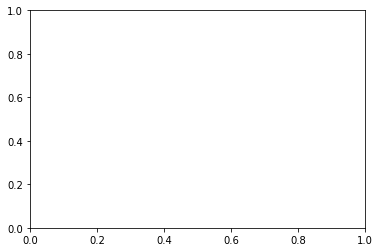

In [113]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, 101)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

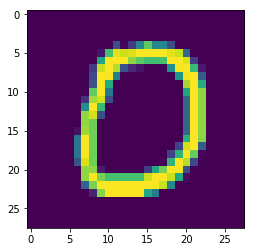

In [90]:
import matplotlib.pyplot as plt
plt.imshow(x_test[10].reshape(28, 28))

In [95]:
print(np.shape(encoder.predict(x_test[0])))

ValueError: Error when checking input: expected input_4 to have 4 dimensions, but got array with shape (28, 28, 1)